In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

# Example running on test data. This part will not require integration.

For running the example you can find test data and pretrained model
here:

https://www.dropbox.com/sh/2yz76iidhwk9k1l/AAANFkXNIJW3o5QIwpQf8Azqa?dl=0

Please download the "test_data" and "models" directories. Where these are
stored is configured below.

In [2]:
cat_dir = '/cephfs/pic.es/astro/scratch/lcabayol/background_estimation/'
data_dir = '/cephfs/pic.es/astro/scratch/lcabayol/background_estimation/img_test'

img_fname = 'red_paucam.12753.1003.0221.FT_NB615_NB685.2469534.std.01.fits'
img_path = os.path.join(data_dir, img_fname)

model_dir = '/cephfs/pic.es/astro/scratch/lcabayol/background_estimation/models_bkg/'


In [3]:
import libexample
from astropy.io import fits

# Band and exposure numbers
band = libexample.get_band(img_path)
exp_num = libexample.get_expnum(img_path)

# Image
hdul = fits.open(img_path)
img = hdul[0].data

# Pixel positions
cosmos_path = os.path.join(cat_dir,'cosmos.csv')
refcat = libexample.load_cosmos(cosmos_path)

header = fits.getheader(img_path)
header['CTYPE1'], header['CTYPE2'] = 'RA---TPV','DEC--TPV'

coords_pix = libexample.get_pixelpos(refcat, header)
coords_pix = coords_pix.drop_duplicates()

coords_pix = coords_pix[(coords_pix.x > 0)&(coords_pix.y > 0)&(coords_pix.y < 2048)&(coords_pix.x < 4096)]

In [4]:
coords_pix = coords_pix.join(refcat, on = ['ref_id'])

In [5]:
coords_pix = coords_pix[coords_pix.exp_num == exp_num]

# Background estimation

In [7]:
import bkgnet

model_path = os.path.join(model_dir, 'model_COSMOS_error_all_v9_34.pt')

net = bkgnet.BKGnet(model_path)
X = net.background_img(img, coords_pix,coords_pix.I_auto.values, band, exp_num)

NB685 1


(0.0, 10.0)

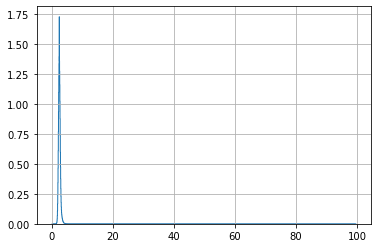

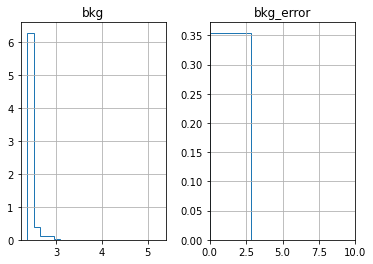

In [9]:
# This code is for making a quick test plot comparing
# the network prediction and individual pixel values in
# the image. These are *not* supposed to be the same, but
# to peak around the same value.
import pandas as pd
K = {'histtype': 'step', 'density': True}
S = pd.Series(img.flatten()) #

S[S < 100].hist(bins=2000, **K)
X.hist(bins=20, **K)

from matplotlib import pyplot as plt
plt.xlim(0, 10)